In [153]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

from skimage.io import imread
from skimage.color import rgb2gray
from skimage.transform import resize

In [154]:
# Define path to the data directory
data_dir = Path('chest_xray')

# Path to train directory
train_dir = data_dir / 'train'

# Path to validation directory
val_dir = data_dir / 'val'

# Path to test directory
test_dir = data_dir / 'test'

In [155]:
# Get the path to the normal and pneumonia sub-directories
normal_cases_dir = train_dir / 'NORMAL'
pneumonia_cases_dir = train_dir / 'PNEUMONIA'

# Get the list of all the images
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

# An empty list. We will insert the data into this list in (img_path, label) format
train_data = []

# Go through all the normal cases. The label for these cases will be 0
for img in normal_cases:
    train_data.append((img,0))

# Go through all the pneumonia cases. The label for these cases will be 1
for img in pneumonia_cases:
    train_data.append((img, 1))

# Get a pandas dataframe from the data we have in our list 
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

# Shuffle the data 
train_data = train_data.sample(frac=1.).reset_index(drop=True)

# How the dataframe looks like?
train_data.head()

,image,label
0,chest_xray\train\PNEUMONIA\person1284_bacteria...,1
1,chest_xray\train\NORMAL\IM-0250-0001.jpeg,0
2,chest_xray\train\PNEUMONIA\person1156_virus_19...,1
3,chest_xray\train\PNEUMONIA\person1491_virus_25...,1
4,chest_xray\train\PNEUMONIA\person1639_bacteria...,1


In [156]:
# Get the path to the normal and pneumonia sub-directories
normal_cases_dir = test_dir / 'NORMAL'
pneumonia_cases_dir = test_dir / 'PNEUMONIA'

# Get the list of all the images
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

# An empty list. We will insert the data into this list in (img_path, label) format
test_data = []

# Go through all the normal cases. The label for these cases will be 0
for img in normal_cases:
    test_data.append((img,0))

# Go through all the pneumonia cases. The label for these cases will be 1
for img in pneumonia_cases:
    test_data.append((img, 1))

# Get a pandas dataframe from the data we have in our list 
test_data = pd.DataFrame(test_data, columns=['image', 'label'],index=None)

# Shuffle the data 
test_data = test_data.sample(frac=1.).reset_index(drop=True)

# How the dataframe looks like?
test_data.head()

,image,label
0,chest_xray\test\NORMAL\IM-0103-0001.jpeg,0
1,chest_xray\test\NORMAL\NORMAL2-IM-0311-0001.jpeg,0
2,chest_xray\test\NORMAL\NORMAL2-IM-0280-0001.jpeg,0
3,chest_xray\test\PNEUMONIA\person75_virus_136.jpeg,1
4,chest_xray\test\PNEUMONIA\person1668_virus_288...,1


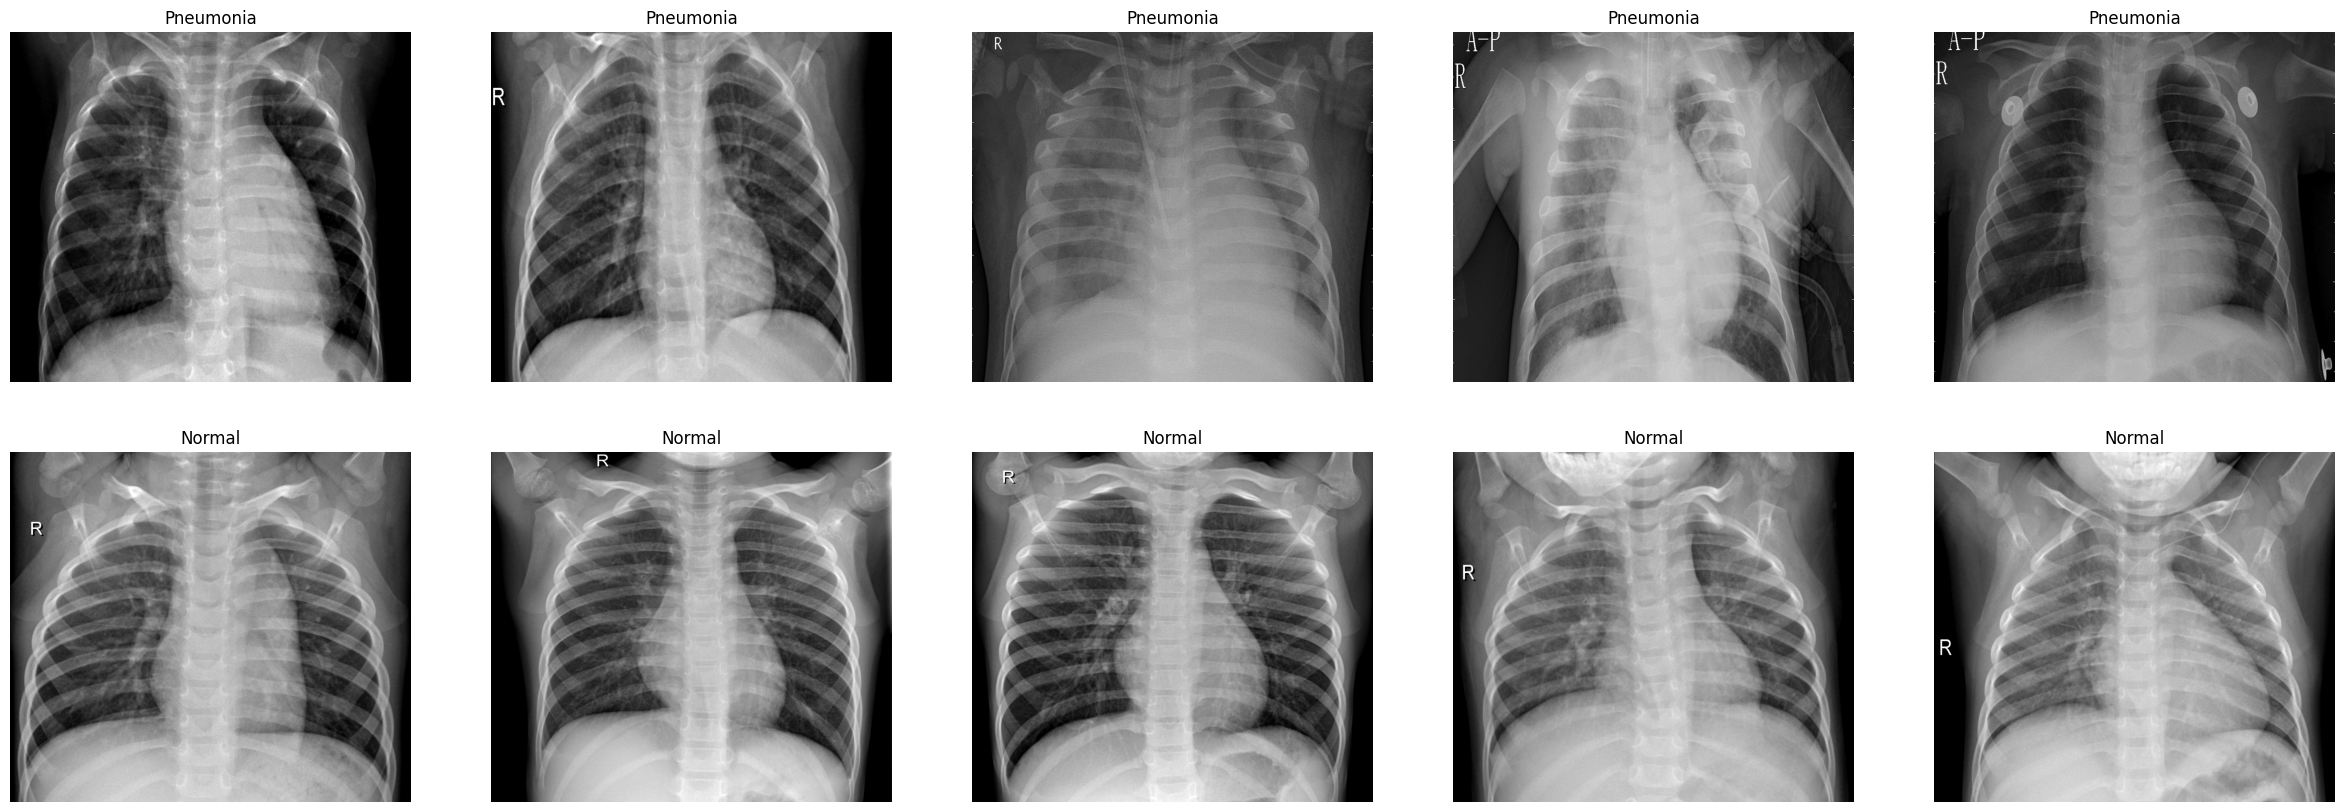

In [157]:
# Get few samples for both the classes
pneumonia_samples = (train_data[train_data['label']==1]['image'].iloc[:5]).tolist()
normal_samples = (train_data[train_data['label']==0]['image'].iloc[:5]).tolist()

# Concat the data in a single list and del the above two list
samples = pneumonia_samples + normal_samples
del pneumonia_samples, normal_samples

# Plot the data 
_, ax = plt.subplots(2,5, figsize=(30,10))
for i in range(10):
    img = imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("Pneumonia")
    else:
        ax[i//5, i%5].set_title("Normal")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

In [158]:
sizes = []
for imgPath in train_data['image']:
    img = imread(imgPath)
    size = img.shape
    sizes.append(size)

train_data['size'] = sizes
train_data

,image,label,size
0,chest_xray\train\PNEUMONIA\person1284_bacteria...,1,"(986, 1434)"
1,chest_xray\train\NORMAL\IM-0250-0001.jpeg,0,"(1368, 1550)"
2,chest_xray\train\PNEUMONIA\person1156_virus_19...,1,"(990, 1492)"
3,chest_xray\train\PNEUMONIA\person1491_virus_25...,1,"(824, 1272)"
4,chest_xray\train\PNEUMONIA\person1639_bacteria...,1,"(688, 1248)"
...,...,...,...
5211,chest_xray\train\PNEUMONIA\person924_bacteria_...,1,"(752, 920)"
5212,chest_xray\train\PNEUMONIA\person547_bacteria_...,1,"(475, 856, 3)"
5213,chest_xray\train\PNEUMONIA\person669_virus_125...,1,"(435, 929, 3)"
5214,chest_xray\train\PNEUMONIA\person38_bacteria_1...,1,"(600, 1040)"


In [159]:
ratios = []
lengths = []
for size in train_data['size']:
  length = size[1] * size[0]
  ratio = size[1] / size[0]
  lengths.append(length)
  ratios.append(ratio)

train_data['length'] = lengths
train_data['ratio'] = ratios
train_data

,image,label,size,length,ratio
0,chest_xray\train\PNEUMONIA\person1284_bacteria...,1,"(986, 1434)",1413924,1.454361
1,chest_xray\train\NORMAL\IM-0250-0001.jpeg,0,"(1368, 1550)",2120400,1.133041
2,chest_xray\train\PNEUMONIA\person1156_virus_19...,1,"(990, 1492)",1477080,1.507071
3,chest_xray\train\PNEUMONIA\person1491_virus_25...,1,"(824, 1272)",1048128,1.543689
4,chest_xray\train\PNEUMONIA\person1639_bacteria...,1,"(688, 1248)",858624,1.813953
...,...,...,...,...,...
5211,chest_xray\train\PNEUMONIA\person924_bacteria_...,1,"(752, 920)",691840,1.223404
5212,chest_xray\train\PNEUMONIA\person547_bacteria_...,1,"(475, 856, 3)",406600,1.802105
5213,chest_xray\train\PNEUMONIA\person669_virus_125...,1,"(435, 929, 3)",404115,2.135632
5214,chest_xray\train\PNEUMONIA\person38_bacteria_1...,1,"(600, 1040)",624000,1.733333


We will find the minimum vector length and find the dimension to which we should resize all images

In [160]:
minLength = train_data['length'].min()
print(minLength)

# We will rescale all images into x*x images
x = int(np.sqrt(minLength))
x

48768


220

In [161]:
def makeDataset(data):
    dataset = ""
    for location in data:
        # reading the image from location
        img = imread(location)
        
        # turning rgb images to grayscale
        if len(img.shape) == 3:
            img = rgb2gray(img)

        # resizing to our desired size and scaling it to 255
        img = resize(img, (x, x), anti_aliasing=True) * 255

        # converting to uint8 for saving memory
        img = img.astype(np.uint8)

        # converting to vector
        img = img.reshape(-1)

        # initiating dataset or vstacking onto dataset
        if type(dataset) == str:
            dataset = img
        else:
            dataset = np.vstack([dataset, img])

    # returning dataset
    return dataset

In [162]:
train_size = 250
test_size = 75

X_train = makeDataset(train_data['image'][:train_size])
y_train = train_data['label'][:train_size]
X_test = makeDataset(test_data['image'][:test_size])
y_test = test_data['label'][:test_size]

In [163]:
from sklearn.linear_model import LogisticRegression

logReg = LogisticRegression()
logReg.fit(X_train, y_train)


c:\Users\alex9\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [164]:
from sklearn.metrics import accuracy_score

y_pred = logReg.predict(X_test)
accuracy_score(y_test, y_pred)

0.68